<font color='blue'> **<font color='red'> **11_** </font> 13_ SRT_LAK_MRV_** </font> 

In [1]:
from modflow_devtools.misc import get_env;write=get_env("WRITE",True);run=get_env("RUN",True)  ; plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
import os;import flopy;import matplotlib.pyplot as plt;import numpy as np;import pickle        ; from pathlib import Path;from flopy.plot.styles import styles;import pandas as pd ; import csv
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'                                             ; REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MF6/11_ex-gwf-sfr-p01')   ; ID= "e11"
_R=Path("./_R");_R.mkdir(exist_ok=True)  ;T11=Path("./_R/T11");T11.mkdir(exist_ok=True);T11b=Path("./_R/T11/b");T11b.mkdir(exist_ok=True)        ; import shutil
with open(REF1/ "a_sfr_pakdata" ,'rb') as handle: SFR_P  = pickle.load(handle)   
with open(REF1/ "b_sfr_conn   " ,'rb') as handle: SFR_C  = pickle.load(handle)                 # SFR_P; SFR_C; SFR_D; SFR_S     ;GHB_S; WEL_S; IDO; TOP; RCH; SURF     ; OBS_F; OBS_D 
with open(REF1/ "c_sfr_div    " ,'rb') as handle: SFR_D  = pickle.load(handle)   
with open(REF1/ "d_sfr_spd    " ,'rb') as handle: SFR_S  = pickle.load(handle)  
with open(REF1/ "e_ghb_spd    " ,'rb') as handle: GHB_S  = pickle.load(handle)  
with open(REF1/ "f_wel_spd    " ,'rb') as handle: WEL_S  = pickle.load(handle)                 # https://modflow6-examples.readthedocs.io/en/develop/_examples/ex-gwf-sfr-p01.html
#with open(REF1/ "obs_list    " ,'rb')  as handle: OBS_L  = pickle.load(handle)   
IDO  = np.loadtxt(REF1/"idomain.txt" , dtype = int)       ; TOP = np.loadtxt(REF1/"top.txt"  ,dtype = float)  ; BOTM  = np.loadtxt(REF1/"bottom.txt", dtype = float) 
RCH  = np.loadtxt(REF1/"recharge.txt", dtype = float)     ; SURF = np.loadtxt(REF1/"surf.txt",dtype = float)   

In [2]:
nlay=1;nrow=15;ncol=10  ;delr=5000;delc=5000                                  ; STRT=1050  ; SS=0.000001 ; EVPT = 0.000000095    ; DEPTH = 15        # print('TDIS (50+50y pump/recovery)=', TDIS)
K11_S = 0.002  ;SY_S=0.2 ;K11_B = 0.0004  ; SY_B = 0.1                        ; nouter = 100 ; ninner = 50 ; hclose = 0.000001   ; rclose = 0.000001
nper=3;TDIS=((0.0 ,1 ,1.0),(1.577880e9 ,50 ,1.1),(1.577880e9 ,50 ,1.1))       ; extents = (0.0, delr * ncol, 0.0, delc * nrow)   ; shape2d = (nrow, ncol)                  
K11 = np.zeros(shape2d, dtype=float)   ; K11[IDO==1]=K11_S ;K11[IDO==2]=K11_B ; SY = np.zeros(shape2d, dtype=float)    ; SY[IDO  == 1] =  SY_S  ; SY[IDO  == 2] =  SY_B   
OBS_F = f"{ID}.sfr.obs"  ; csv_file = OBS_F + ".csv"    
OBS_D = {csv_file: [("r01_H", "stage", (3,))            ,("r02_H", "stage", (14,))            ,("r03_H", "stage", (26,))            ,("r04_H", "stage"          , (35,)),
                    ("r01_F", "downstream-flow", (3,))  ,("r02_F", "downstream-flow", (14,))  ,("r03_F", "downstream-flow" ,(26,))  ,("r04_F", "downstream-flow", (35,))]}

In [3]:
def build_models():
    sim = flopy.mf6.MFSimulation  (sim_name=ID   ,sim_ws=T11b     ,exe_name="mf6")
    flopy.mf6.ModflowTdis    (sim, nper=nper     ,perioddata=TDIS ,time_units="seconds")                                                                      ;aa = "summary"; bb = "bicgstab"
    flopy.mf6.ModflowIms     (sim,print_option=aa,linear_acceleration=bb, outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf    (sim, modelname=ID, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf,length_units="feet",nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,idomain=IDO,top=TOP,botm=BOTM)    ; flopy.mf6.ModflowGwfrcha (gwf, recharge=RCH)
    flopy.mf6.ModflowGwfnpf  (gwf,icelltype=1,k=K11,save_specific_discharge=True)      ; flopy.mf6.ModflowGwfsto(gwf, iconvert=1,sy=SY,ss=SS,steady_state={0: True},transient={1: True})
    flopy.mf6.ModflowGwfic   (gwf, strt=STRT)                                          ; flopy.mf6.ModflowGwfghb(gwf, stress_period_data=GHB_S)
    flopy.mf6.ModflowGwfwel  (gwf, stress_period_data=WEL_S)                           ; flopy.mf6.ModflowGwfevta (gwf, surface=SURF, rate=EVPT, depth=DEPTH)
    sfr = flopy.mf6.ModflowGwfsfr (gwf,length_conversion=3.28081,nreaches=len(SFR_P),packagedata=SFR_P,connectiondata=SFR_C,  diversions=SFR_D,perioddata=SFR_S)
    sfr.obs.initialize       (filename=OBS_F, digits=10, print_input=True, continuous=OBS_D)                                  ; HF=f"{ID}.hds";BF=f"{ID}.cbc"
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=HF,budget_filerecord=BF,saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])  ; return sim
def write_models(sim, silent=True):  sim.write_simulation(silent=silent)
def run_models(sim, silent=True):    success, buff = sim.run_simulation(silent=silent) ; assert success, buff
def scenario():
    sim = build_models()
    if write:    write_models(sim, silent=True)
    if run:      run_models  (sim, silent=True)
scenario()

<font color='blue'> **RES** </font> 

In [4]:
sim = flopy.mf6.MFSimulation.load (sim_ws = T11b ,exe_name=exe_name, verbosity_level=0)  ;ML=sim.get_model("e11");HOBJ=ML.output.head();COBJ=ML.output.budget();kstpkper=HOBJ.get_kstpkper() 
SA =np.max(TOP)-np.min(TOP)     ;LT=np.arange(np.min(TOP[0]),np.max(TOP[0]), SA/60)  ;SB=np.max(BOTM)-np.min(BOTM)              ; LEV=np.arange(np.min(BOTM[0]), np.max(BOTM[0]), SB/10)    

Y0=0; head0 = HOBJ.get_data(kstpkper=kstpkper[Y0])    ;QX0,QY0,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y0])[0], ML)
Y1=1; head1 = HOBJ.get_data(kstpkper=kstpkper[Y1])    ;QX1,QY1,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y1])[0], ML)

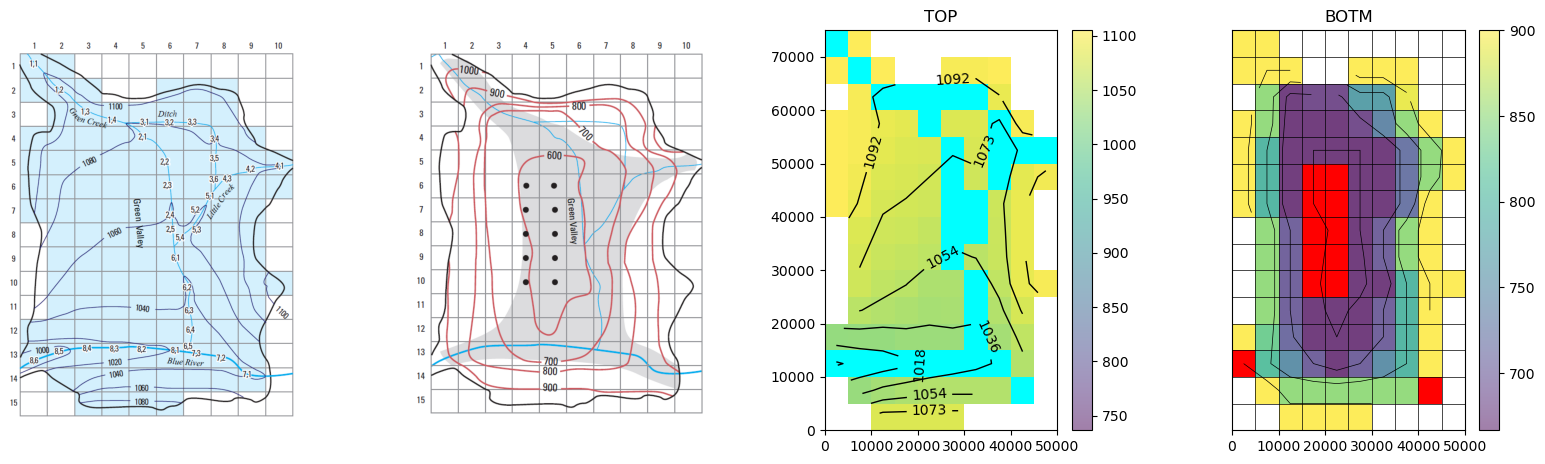

In [5]:
fig = plt.figure(figsize=(17, 5), dpi=100)        
ax = fig.add_subplot(141)            ;image=plt.imread('E:/15_REPOS/00_BETAMI/01_MF6/_aux/30_11_SRF2.png') ;ax.imshow(image) ;ax.axis('off')
ax = fig.add_subplot(142)            ;image=plt.imread('E:/15_REPOS/00_BETAMI/01_MF6/_aux/30_11_SRF1.png') ;ax.imshow(image) ;ax.axis('off')
plt.subplots_adjust(left=0.01, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)
ax = fig.add_subplot(143)            ; ax.set_title("TOP")  # ________________________________________________________________________________________________________________________________
mm=flopy.plot.PlotMapView(ML,ax=ax)  ;TC=mm.plot_array(TOP,vmin=np.max(TOP[0])/1.5,vmax=np.max(TOP[0]),masked_values=(0,1e30,-1e30),alpha=0.5)       ; cbar=plt.colorbar(TC,ax=ax, format="%.0f")
mm.plot_bc("SFR", color="cyan") ; CV = mm.contour_array(TOP,levels=LT,linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))     ; plt.clabel(CV, fmt="%1.0f")
ax = fig.add_subplot(144)            ; ax.set_title("BOTM") # ________________________________________________________________________________________________________________________________
mm=flopy.plot.PlotMapView(ML,ax=ax)  ;CO=mm.plot_array(BOTM,vmin=np.max(BOTM[0])/1.5,vmax=np.max(BOTM[0])*.9,masked_values=(0,1e30,-1e30),alpha=0.5) ; cbar=plt.colorbar(CO,ax=ax,format="%.0f")
ct = mm.contour_array(BOTM,levels=LEV,linewidths=0.5,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30)) ; mm.plot_bc("GHB", color="red")  ; mm.plot_bc("WEL",color="red",kper=1)
mm.plot_grid(lw=0.5, color="black") ; ax.yaxis.set_visible(False) ; plt.show()                                                                      #; plt.clabel(ct, fmt="%1.0f")

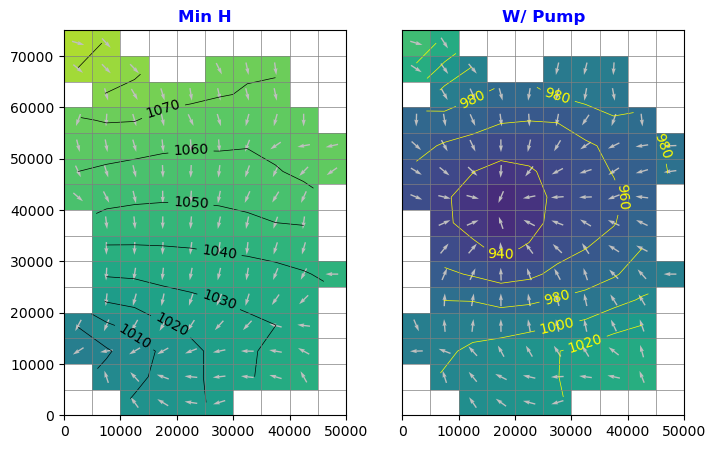

In [6]:
fig = plt.figure(figsize=(8, 5))                                                          # ; print('Min H', round(np.min(head0[0]),0), '____ Min H pump',round(np.min(head1[0]),0))
ax = fig.add_subplot(121)   # _______________________________________________________________________________________________________    
ax.set_title('Min H',fontweight='bold', color='blue')  ;mm=flopy.plot.PlotMapView(ML,ax=ax,extent=extents)  ;HC=mm.plot_array(head0,vmin=900,vmax=1120,masked_values=(0,1e30,-1e30))
CV = mm.contour_array(head0,levels=np.arange(900, 1100, 10),linewidths=0.5,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
plt.clabel(CV, fmt="%1.0f") ; mm.plot_vector(QX0, QY0, normalize=True, color="0.75")   ;mm.plot_grid(lw=0.5)  
ax = fig.add_subplot(122)   # _______________________________________________________________________________________________________
ax.set_title('W/ Pump',fontweight='bold',color='b')   ;mn = flopy.plot.PlotMapView(ML,ax=ax,extent=extents) ;HC=mn.plot_array(head1,vmin=900,vmax=1120,masked_values=(0, 1e30,-1e30))
CV = mn.contour_array(head1,levels=np.arange(900, 1100, 20),linewidths=0.5,linestyles="-",colors="yellow",masked_values=(0, 1e30, -1e30))
plt.clabel(CV, fmt="%1.0f") ; mn.plot_vector(QX1, QY1, normalize=True, color="0.75")   ;mn.plot_grid(lw=0.5)                               ; ax.yaxis.set_visible(False) ; plt.show()

In [7]:
DF = pd.read_csv(T11b/'e11.sfr.obs.csv') ; DF['R01_F']=DF['R01_F']*-1 ;DF['R02_F']=DF['R02_F']*-1 ;DF['R03_F']=DF['R03_F']*-1;DF['R04_F']=DF['R04_F']*-1; DF.tail(2)

,time,R01_H,R02_H,R03_H,R04_H,R01_F,R02_F,R03_F,R04_F
99,3.011084e+09,1078.416789,1061.581,1026.282453,993.311600,16.430161,3.582622,3.694812,153.667609
100,3.155760e+09,1078.416827,1061.581,1026.282745,993.311633,16.431243,3.584552,3.699299,153.673550


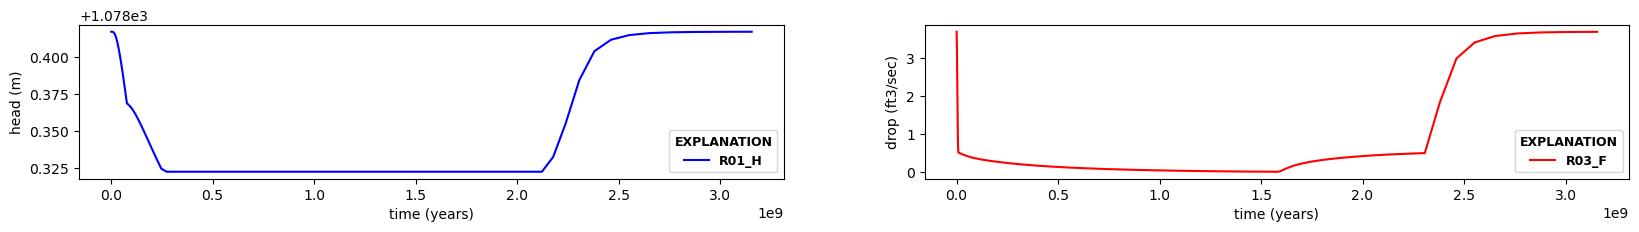

In [8]:
HH=[DF.columns[1]] ; QQ=[DF.columns[-2]]
fig = plt.figure(figsize=(20,2))                                                         
ax = fig.add_subplot(121)   ; ax.plot(DF['time'],DF[HH],label=HH,color='blue')  ; ax.set_xlabel("time (years)")  ;ax.set_ylabel("head (m)")        ;styles.graph_legend(ax) 
ax = fig.add_subplot(122)   ; ax.plot(DF['time'],DF[QQ],label=QQ,color='red')   ; ax.set_xlabel("time (years)")  ;ax.set_ylabel("drop (ft3/sec)")  ;styles.graph_legend(ax)  ;plt.show()

In [ ]:
pd.DataFrame(os.listdir(T11/'b')).to_csv(T11/"_L11_LIST.csv")              # SFR_P; SFR_C; SFR_D; SFR_S     ;GHB_S; WEL_S; IDO; TOP; RCH; SURF     ; OBS_F; OBS_D 
np.savetxt(T11/"S1.csv",SFR_P,delimiter=",")  ; pd.DataFrame(SFR_C).to_csv(T11/"S2.csv")    ;np.savetxt(T11/"S3.csv",SFR_D,fmt="%s",delimiter=",") ; pd.DataFrame(SFR_S).to_csv(T11/"S4.csv")
np.savetxt(T11/"IDO.csv",IDO,delimiter=",")   ; np.savetxt(T11/"TOP.csv",TOP,delimiter=",") ;np.savetxt(T11/"RCH.csv",RCH,delimiter=",")           ; np.savetxt(T11/"SURF.csv",SURF,delimiter=",")
np.savetxt(T11/"GHB_spd.csv",GHB_S,delimiter=",")  ; pd.DataFrame(OBS_D).to_csv(T11/"OBS_D.csv")  
with open(T11/"WEL_spd.csv", "w", newline="") as ff:     # _____________________________________________ saving
    mm = csv.DictWriter(ff, WEL_S.keys())   ; mm.writeheader()  ; mm.writerow(WEL_S)
with open(T11/"OBS_F.csv", 'w', newline='')   as csvfile:  # _____________________________________________ saving
    writer = csv.writer(csvfile)
    for line in OBS_F.splitlines():           writer.writerow(line.split(','))
shutil.copy(T11b/'e11.sfr.obs.csv', T11/'OBS_F2.csv')                             